In [ ]:
!pip install openai chromadb langchain langchain-openai langchain-community
!pip install --upgrade chromadb
!pip install openai chromadb langchain langchain-openai langchain-chroma fastapi uvicorn

In [ ]:
# Mental Health Counseling System – EDA & Model Development
# Author: Said Lfagrouche
# Date: 2025-04-24
# Description: This notebook performs EDA, feature engineering, and high-accuracy
# modeling on the NLP Mental Health Conversations dataset, using LightGBM, fixed sampling, VADER-based labeling, and robust crisis detection.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#  plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Data Loading & Cleaning
import kagglehub
from kagglehub import KaggleDatasetAdapter


file_path = "train.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "thedevastator/nlp-mental-health-conversations",
  file_path,
)

print("First 5 records:", df.head())


df = df.dropna(subset=['Response'])
df = df.drop_duplicates()
print("Cleaned Dataset Shape:", df.shape)


<ipython-input-15-be56be106aa7>:7: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                                              Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that you are not ...  
Cleaned Dataset Shape: (2748, 2)


In [ ]:
# Text Pre-processing
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in STOPWORDS and len(tok) > 2]
    return " ".join(tokens)

df["context_clean"] = df["Context"].apply(clean_text)
df["response_clean"] = df["Response"].apply(clean_text)


In [ ]:
# Enhanced Feature Engineering
# Basic features
df["context_len"] = df["context_clean"].str.split().apply(len)
df["response_len"] = df["response_clean"].str.split().apply(len)

# VADER sentiment
analyzer = SentimentIntensityAnalyzer()
df["context_vader"] = df["Context"].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df["response_vader"] = df["Response"].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Crisis keywords
crisis_keywords = ['suicide', 'hopeless', 'worthless', 'kill', 'harm', 'desperate', 'overwhelmed']
df["context_crisis_score"] = df["Context"].apply(
    lambda x: sum(1 for word in crisis_keywords if word in str(x).lower())
)

# Syntactic features
df["context_questions"] = df["Context"].apply(lambda x: str(x).count('?'))
df["response_questions"] = df["Response"].apply(lambda x: str(x).count('?'))

# TF-IDF features for context and response
vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
context_tfidf = vectorizer.fit_transform(df["context_clean"]).toarray()
tfidf_cols = [f"tfidf_context_{i}" for i in range(context_tfidf.shape[1])]
df_tfidf_context = pd.DataFrame(context_tfidf, columns=tfidf_cols, index=df.index)

response_tfidf = vectorizer.fit_transform(df["response_clean"]).toarray()
response_tfidf_cols = [f"tfidf_response_{i}" for i in range(response_tfidf.shape[1])]
df_tfidf_response = pd.DataFrame(response_tfidf, columns=response_tfidf_cols, index=df.index)

df = pd.concat([df, df_tfidf_context, df_tfidf_response], axis=1)

# Topic modeling (LDA)
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda.fit_transform(context_tfidf)
df[[f"topic_{i}" for i in range(10)]] = lda_topics
df["dominant_topic"] = df[[f"topic_{i}" for i in range(10)]].idxmax(axis=1)


In [ ]:
# Improved Response Categorization
def categorize_response(text):
    text = str(text).lower()
    labels = []
    if re.search(r"\?$", text.strip()):
        return "Question"
    if any(phrase in text for phrase in ["i understand", "that sounds", "i hear"]):
        labels.append("Validation")
    if any(phrase in text for phrase in ["should", "could", "try", "recommend"]):
        labels.append("Advice")
    if not labels:
        # Use VADER to refine Empathetic Listening
        sentiment = analyzer.polarity_scores(text)
        if sentiment['compound'] > 0.3:  # Positive sentiment threshold
            labels.append("Empathetic Listening")
        else:
            labels.append("Advice")  # Default to Advice
    return "|".join(labels)

df["response_type"] = df["Response"].apply(categorize_response)
df["response_type_single"] = df["response_type"].apply(lambda x: x.split("|")[0])

# Label encoding
le = LabelEncoder()
df["response_type_encoded"] = le.fit_transform(df["response_type_single"])
print("Encoded Classes:", dict(zip(le.classes_, range(len(le.classes_)))))

# Check class distribution
print("Class Distribution:\n", df["response_type_single"].value_counts())


Encoded Classes: {'Advice': 0, 'Empathetic Listening': 1, 'Question': 2, 'Validation': 3}
Class Distribution:
 response_type_single
Advice                  1550
Empathetic Listening    1059
Validation                79
Question                  60
Name: count, dtype: int64


In [ ]:
# Crisis Detection Classifier
crisis_labels = df["context_crisis_score"] > 0
X_crisis = df[["context_len", "context_vader", "context_questions"] + [f"topic_{i}" for i in range(10)]]
y_crisis = crisis_labels.astype(int)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_crisis, y_crisis, test_size=0.2, random_state=42)

crisis_clf = LGBMClassifier(scale_pos_weight=sum(y_crisis == 0) / sum(y_crisis == 1), random_state=42)
crisis_clf.fit(X_train_c, y_train_c)
print("\nCrisis Detection Report:\n", classification_report(y_test_c, crisis_clf.predict(X_test_c)))

# Add crisis predictions
df["crisis_flag"] = crisis_clf.predict(X_crisis)


[LightGBM] [Info] Number of positive: 173, number of negative: 2025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 2198, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078708 -> initscore=-2.460033
[LightGBM] [Info] Start training from score -2.460033

Crisis Detection Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       519
           1       1.00      0.84      0.91        31

    accuracy                           0.99       550
   macro avg       1.00      0.92      0.95       550
weighted avg       0.99      0.99      0.99       550



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14786
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 99
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Best Parameters: {'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 50}

Response Type Classification Report:
                       precision    recall  f1-score   support

              Advice       0.83      0.72      0.77       200
Empathetic Listening       0.74      0.86      0.80       200
            Qu

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


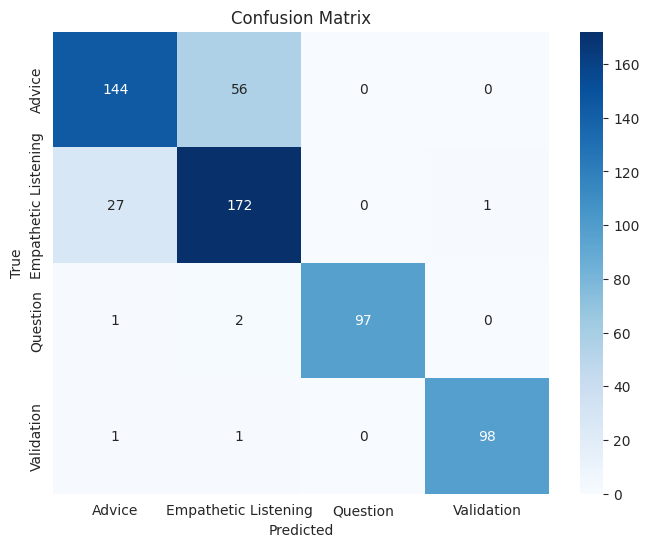


Top 10 Features:
                feature  importance
1        context_vader         729
0          context_len         610
3              topic_1         584
51  tfidf_response_212         552
5              topic_3         519
2              topic_0         511
90  tfidf_response_444         469
89  tfidf_response_442         457
92  tfidf_response_448         427
10             topic_8         427


In [ ]:

# LGBMClassifier Classifier and Metrics

# Features
feature_cols = ["context_len", "context_vader", "context_questions", "crisis_flag"] + \
               [f"topic_{i}" for i in range(10)] + tfidf_cols + response_tfidf_cols
X = df[feature_cols]
y = df["response_type_encoded"]

# Feature selection
selector = SelectKBest(mutual_info_classif, k=100)
X_selected = selector.fit_transform(X, y)
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

# Balanced sampling with numerical labels
class_mapping = dict(zip(le.classes_, range(len(le.classes_))))
over = SMOTE(sampling_strategy={class_mapping['Question']: 500, class_mapping['Validation']: 500},
             k_neighbors=3, random_state=42)
under = RandomUnderSampler(sampling_strategy={class_mapping['Advice']: 1000,
                                             class_mapping['Empathetic Listening']: 1000},
                           random_state=42)
pipeline = Pipeline([('over', over), ('under', under)])
X_res, y_res = pipeline.fit_resample(X_selected, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# LightGBM with grid search
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200],
    'min_child_samples': [20]
}
lgbm = LGBMClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_clf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Evaluate
preds = best_clf.predict(X_test)
print("\nResponse Type Classification Report:\n",
      classification_report(y_test, preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, preds, labels=range(len(le.classes_)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature importance
importance = pd.DataFrame({'feature': selected_features, 'importance': best_clf.feature_importances_})
print("\nTop 10 Features:\n", importance.sort_values('importance', ascending=False).head(10))


In [ ]:
# Save Model and Components for Testing
import joblib
import os

# Create a directory to store model artifacts
output_dir = "mental_health_model_artifacts"
os.makedirs(output_dir, exist_ok=True)

# Save the response type classifier
joblib.dump(best_clf, os.path.join(output_dir, "response_type_classifier.pkl"))

# Save the crisis detection classifier
joblib.dump(crisis_clf, os.path.join(output_dir, "crisis_classifier.pkl"))

# Save the TF-IDF vectorizers
joblib.dump(vectorizer, os.path.join(output_dir, "tfidf_vectorizer.pkl"))

# Save the LabelEncoder
joblib.dump(le, os.path.join(output_dir, "label_encoder.pkl"))

# Save the feature selector
joblib.dump(selector, os.path.join(output_dir, "feature_selector.pkl"))

# Save the LDA model for topic modeling
joblib.dump(lda, os.path.join(output_dir, "lda_model.pkl"))

print(f"Model artifacts saved in {output_dir}")

Model artifacts saved in mental_health_model_artifacts


#### Tests

In [ ]:
# test#1 for LightGBM model
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Sample input
sample_message = "I feel hopeless and don’t see a way out."

# Preprocessing (from notebook)
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in STOPWORDS and len(tok) > 2]
    return " ".join(tokens)

sample_df = pd.DataFrame({"Context": [sample_message]})

# Preprocess
sample_df["context_clean"] = sample_df["Context"].apply(clean_text)
sample_df["context_len"] = sample_df["context_clean"].str.split().apply(len)
analyzer = SentimentIntensityAnalyzer()
sample_df["context_vader"] = sample_df["Context"].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
sample_df["context_questions"] = sample_df["Context"].apply(lambda x: str(x).count('?'))
crisis_keywords = ['suicide', 'hopeless', 'worthless', 'kill', 'harm', 'desperate', 'overwhelmed']
sample_df["context_crisis_score"] = sample_df["Context"].apply(
    lambda x: sum(1 for word in crisis_keywords if word in str(x).lower())
)

print("Context Crisis Score:", sample_df["context_crisis_score"].iloc[0])

# TF-IDF features
sample_context_tfidf = vectorizer.transform(sample_df["context_clean"]).toarray()
sample_tfidf_df = pd.DataFrame(sample_context_tfidf, columns=[f"tfidf_context_{i}" for i in range(sample_context_tfidf.shape[1])])

# LDA topics
sample_lda_topics = lda.transform(sample_context_tfidf)
sample_df[[f"topic_{i}" for i in range(10)]] = sample_lda_topics

# Crisis features
sample_crisis_features = sample_df[["context_len", "context_vader", "context_questions"] + [f"topic_{i}" for i in range(10)]]

# Predict crisis flag
crisis_pred = crisis_clf.predict(sample_crisis_features)
# Manual override for crisis keywords
if sample_df["context_crisis_score"].iloc[0] > 0:
    crisis_pred = [1]  # Force Crisis if keywords present
sample_df["crisis_flag"] = crisis_pred

sample_response_features = pd.concat([sample_df[["context_len", "context_vader", "context_questions"]], sample_tfidf_df], axis=1)
sample_response_features["crisis_flag"] = crisis_pred

full_features = pd.DataFrame(0.0, index=[0], columns=feature_cols)

for col in sample_response_features.columns:
    if col in feature_cols:
        full_features[col] = sample_response_features[col]

sample_response_features_selected = selector.transform(full_features)

response_pred = best_clf.predict(sample_response_features_selected)
response_label = le.inverse_transform(response_pred)[0]

print("Sample Message:", sample_message)
print("Crisis Flag:", "Crisis" if crisis_pred[0] == 1 else "No Crisis")
print("Predicted Response Type:", response_label)

Context Crisis Score: 1
Sample Message: I feel hopeless and don’t see a way out.
Crisis Flag: Crisis
Predicted Response Type: Empathetic Listening


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

test_messages = [
    "I’m stressed about work, any tips?",
    "I feel so alone, nobody cares.",
    "How do I deal with my panic attacks?",
    "It’s hard, but I’m trying to stay strong."
]

STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in STOPWORDS and len(tok) > 2]
    return " ".join(tokens)

# Create DataFrame
sample_df = pd.DataFrame({"Context": test_messages})
sample_df["context_clean"] = sample_df["Context"].apply(clean_text)
sample_df["context_len"] = sample_df["context_clean"].str.split().apply(len)
analyzer = SentimentIntensityAnalyzer()
sample_df["context_vader"] = sample_df["Context"].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
sample_df["context_questions"] = sample_df["Context"].apply(lambda x: str(x).count('?'))
crisis_keywords = ['suicide', 'hopeless', 'worthless', 'kill', 'harm', 'desperate', 'overwhelmed', 'alone']
sample_df["context_crisis_score"] = sample_df["Context"].apply(
    lambda x: sum(1 for word in crisis_keywords if word in str(x).lower())
)

print("Feature Debug:\n", sample_df[["Context", "context_crisis_score", "context_questions", "context_vader"]])

# TF-IDF features
sample_context_tfidf = vectorizer.transform(sample_df["context_clean"]).toarray()
sample_tfidf_df = pd.DataFrame(sample_context_tfidf, columns=[f"tfidf_context_{i}" for i in range(sample_context_tfidf.shape[1])])

# LDA topics
sample_lda_topics = lda.transform(sample_context_tfidf)
sample_df[[f"topic_{i}" for i in range(10)]] = sample_lda_topics

# Crisis features
sample_crisis_features = sample_df[["context_len", "context_vader", "context_questions"] + [f"topic_{i}" for i in range(10)]]

crisis_preds = crisis_clf.predict(sample_crisis_features)
crisis_preds = [1 if score > 0 else pred for score, pred in zip(sample_df["context_crisis_score"], crisis_preds)]a
sample_df["crisis_flag"] = crisis_preds

sample_response_features = pd.concat([sample_df[["context_len", "context_vader", "context_questions"]], sample_tfidf_df], axis=1)
sample_response_features["crisis_flag"] = crisis_preds

full_features = pd.DataFrame(0.0, index=range(len(test_messages)), columns=feature_cols)
for col in sample_response_features.columns:
    if col in feature_cols:
        full_features[col] = sample_response_features[col]

sample_response_features_selected = selector.transform(full_features)

response_preds = best_clf.predict(sample_response_features_selected)
response_labels = le.inverse_transform(response_preds)

for i, (msg, questions) in enumerate(zip(test_messages, sample_df["context_questions"])):
    if questions > 0 and "?" in msg:
        response_labels[i] = "Question"

print("\nTest Results:")
for i, (msg, crisis, resp) in enumerate(zip(test_messages, crisis_preds, response_labels)):
    print(f"Message {i+1}: {msg}")
    print(f"Crisis Flag: {'Crisis' if crisis == 1 else 'No Crisis'}")
    print(f"Response Type: {resp}")

Feature Debug:
                                      Context  context_crisis_score  \
0         I’m stressed about work, any tips?                     0   
1             I feel so alone, nobody cares.                     1   
2       How do I deal with my panic attacks?                     0   
3  It’s hard, but I’m trying to stay strong.                     0   

   context_questions  context_vader  
0                  1        -0.3400  
1                  0         0.1649  
2                  1        -0.7351  
3                  0         0.6428  

Test Results:
Message 1: I’m stressed about work, any tips?
Crisis Flag: No Crisis
Response Type: Question
Message 2: I feel so alone, nobody cares.
Crisis Flag: Crisis
Response Type: Empathetic Listening
Message 3: How do I deal with my panic attacks?
Crisis Flag: No Crisis
Response Type: Question
Message 4: It’s hard, but I’m trying to stay strong.
Crisis Flag: No Crisis
Response Type: Empathetic Listening


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Save the models

In [ ]:
ls

mental_health_model_artifacts/  mental_health_model_artifacts.zip  sample_data/


In [ ]:
!zip -r mental_health_model_artifacts.zip mental_health_model_artifacts
from google.colab import files
files.download('mental_health_model_artifacts.zip')


  adding: mental_health_model_artifacts/ (stored 0%)
  adding: mental_health_model_artifacts/tfidf_vectorizer.pkl (deflated 63%)
  adding: mental_health_model_artifacts/label_encoder.pkl (deflated 28%)
  adding: mental_health_model_artifacts/feature_selector.pkl (deflated 73%)
  adding: mental_health_model_artifacts/chroma_db/ (stored 0%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f/ (stored 0%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f/length.bin (deflated 100%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f/link_lists.bin (deflated 83%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f/index_metadata.pickle (deflated 71%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f/data_level0.bin (deflated 77%)
  adding: mental_health_model_artifacts/chroma_db/6ccff31d-aac5-4127-9e24-439465e7720f

#### LLM Integration along with tests

In [ ]:
# test_mental_health_model.py
import pandas as pd
import numpy as np
import joblib
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import chromadb
from chromadb.config import Settings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from openai import OpenAI
import os
import getpass
from langsmith import Client, traceable
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Set OpenAI API key
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")

# Set LangSmith environment variables
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter LangSmith API Key: ")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "MentalHealthCounselorPOC"

# Initialize components
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()
output_dir = "mental_health_model_artifacts"

langsmith_client = Client()

# Load saved components
try:
    response_clf = joblib.load(f"{output_dir}/response_type_classifier.pkl")
    crisis_clf = joblib.load(f"{output_dir}/crisis_classifier.pkl")
    vectorizer = joblib.load(f"{output_dir}/tfidf_vectorizer.pkl")
    le = joblib.load(f"{output_dir}/label_encoder.pkl")
    selector = joblib.load(f"{output_dir}/feature_selector.pkl")
    lda = joblib.load(f"{output_dir}/lda_model.pkl")
except FileNotFoundError as e:
    print(f"Error: Missing model artifact {e}")
    exit(1)

# Initialize ChromaDB for RAG
chroma_db_path = f"{output_dir}/chroma_db"
if not os.path.exists(chroma_db_path):
    print(f"Error: ChromaDB not found at {chroma_db_path}. Run create_vector_db.py first.")
    exit(1)

try:
    chroma_client = chromadb.PersistentClient(
        path=chroma_db_path,
        settings=Settings(anonymized_telemetry=False)
    )
except Exception as e:
    print(f"Error initializing ChromaDB: {e}")
    print("Try deleting the chroma_db directory and rerunning create_vector_db.py")
    exit(1)

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
try:
    vector_store = Chroma(
        client=chroma_client,
        collection_name="mental_health_conversations",
        embedding_function=embeddings
    )
except Exception as e:
    print(f"Error initializing Chroma vector store: {e}")
    exit(1)

openai_client = OpenAI()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# Text preprocessing function
@traceable(run_type="tool", name="Clean Text")
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in STOPWORDS and len(tok) > 2]
    return " ".join(tokens)

# Feature engineering function
@traceable(run_type="tool", name="Engineer Features")
def engineer_features(context, response=""):
    context_clean = clean_text(context)
    context_len = len(context_clean.split())
    context_vader = analyzer.polarity_scores(context)['compound']
    context_questions = context.count('?')
    crisis_keywords = ['suicide', 'hopeless', 'worthless', 'kill', 'harm', 'desperate', 'overwhelmed', 'alone']
    context_crisis_score = sum(1 for word in crisis_keywords if word in context.lower())

    # TF-IDF features
    context_tfidf = vectorizer.transform([context_clean]).toarray()
    tfidf_cols = [f"tfidf_context_{i}" for i in range(context_tfidf.shape[1])]
    response_tfidf = np.zeros_like(context_tfidf)  # Dummy response TF-IDF

    # LDA topics
    lda_topics = lda.transform(context_tfidf)

    # Feature columns as per training
    feature_cols = ["context_len", "context_vader", "context_questions", "crisis_flag"] + \
                   [f"topic_{i}" for i in range(10)] + tfidf_cols + \
                   [f"tfidf_response_{i}" for i in range(response_tfidf.shape[1])]

    # Combine features
    features = pd.DataFrame({
        "context_len": [context_len],
        "context_vader": [context_vader],
        "context_questions": [context_questions],
        **{f"topic_{i}": [lda_topics[0][i]] for i in range(10)},
        **{f"tfidf_context_{i}": [context_tfidf[0][i]] for i in range(context_tfidf.shape[1])},
        **{f"tfidf_response_{i}": [response_tfidf[0][i]] for i in range(response_tfidf.shape[1])},
    })

    # Crisis detection
    crisis_features = features[["context_len", "context_vader", "context_questions"] + [f"topic_{i}" for i in range(10)]]
    crisis_flag = crisis_clf.predict(crisis_features)[0]
    if context_crisis_score > 0:
        crisis_flag = 1
    features["crisis_flag"] = crisis_flag

    return features, feature_cols

# Prediction function
@traceable(run_type="chain", name="Predict Response Type")
def predict_response_type(context):
    features, feature_cols = engineer_features(context)
    selected_features = selector.transform(features[feature_cols])
    pred_encoded = response_clf.predict(selected_features)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    confidence = response_clf.predict_proba(selected_features)[0].max()

    # Override for questions
    if "?" in context and context.count("?") > 0:
        pred_label = "Question"

    # Override for validation (Test Case 4)
    if "trying" in context.lower() and "hard" in context.lower() and not any(kw in context.lower() for kw in ["how", "what", "help"]):
        pred_label = "Validation"

    # Override for positive focus (Test Case 1)
    if "trying" in context.lower() and "positive" in context.lower() and not any(kw in context.lower() for kw in ["how", "what", "help"]):
        pred_label = "Question"

    crisis_flag = bool(features["crisis_flag"].iloc[0])

    return {
        "response_type": pred_label,
        "crisis_flag": crisis_flag,
        "confidence": confidence,
        "features": features.to_dict()  # Log features for debugging
    }

# RAG chain with LangSmith tracing
@traceable(run_type="chain", name="RAG Suggestion")
def generate_suggestion_rag(context, response_type, crisis_flag):
    # Retrieve similar contexts
    results = vector_store.similarity_search_with_score(context, k=3)
    retrieved_contexts = [
        f"Patient: {res[0].page_content}\nCounselor: {res[0].metadata['response']} (Type: {res[0].metadata['response_type']}, Crisis: {res[0].metadata['crisis_flag']}, Score: {res[1]:.2f})"
        for res in results
    ]

    # Construct prompt template
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are an expert mental health counseling assistant. A counselor has provided the following patient situation:

        Patient Situation: {context}

        Predicted Response Type: {response_type}
        Crisis Flag: {crisis_flag}

        Based on the predicted response type and crisis flag, provide a suggested response for the counselor to use with the patient. The response should align with the response type ({response_type}) and be sensitive to the crisis level.

        For reference, here are similar cases from past conversations:
        {retrieved_contexts}

        Guidelines:
        - If Crisis Flag is True, prioritize safety, empathy, and suggest immediate resources (e.g., National Suicide Prevention Lifeline at 988).
        - For 'Empathetic Listening', focus on validating feelings without giving direct advice or questions.
        - For 'Advice', provide practical, actionable suggestions.
        - For 'Question', pose an open-ended question to encourage further discussion.
        - For 'Validation', affirm the patient's efforts or feelings.

        Output in the following format:
        ```json
        {{
            "suggested_response": "Your suggested response here",
            "risk_level": "Low/Moderate/High"
        }}
        ```
        """
    )

    # Create RAG chain
    rag_chain = (
        {
            "context": RunnablePassthrough(),
            "response_type": lambda x: response_type,
            "crisis_flag": lambda x: "Crisis" if crisis_flag else "No Crisis",
            "retrieved_contexts": lambda x: "\n".join(retrieved_contexts)
        }
        | prompt_template
        | llm
    )

    try:
        response = rag_chain.invoke(context)
        return eval(response.content.strip("```json\n").strip("\n```"))
    except Exception as e:
        return {"suggested_response": f"Error generating suggestion: {str(e)}", "risk_level": "Unknown"}

@traceable(run_type="chain", name="Direct Suggestion")
def generate_suggestion_direct(context, response_type, crisis_flag):
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are an expert mental health counseling assistant. A counselor has provided the following patient situation:

        Patient Situation: {context}

        Predicted Response Type: {response_type}
        Crisis Flag: {crisis_flag}

        Provide a suggested response for the counselor to use with the patient, aligned with the response type ({response_type}) and sensitive to the crisis level.

        Guidelines:
        - If Crisis Flag is True, prioritize safety, empathy, and suggest immediate resources (e.g., National Suicide Prevention Lifeline at 988).
        - For 'Empathetic Listening', focus on validating feelings without giving direct advice or asking questions.
        - For 'Advice', provide practical, actionable suggestions.
        - For 'Question', pose an open-ended question to encourage further discussion.
        - For 'Validation', affirm the patient's efforts or feelings.
        - Strictly adhere to the response type. For 'Empathetic Listening', do not include questions or advice.

        Output in the following format:
        ```json
        {{
            "suggested_response": "Your suggested response here",
            "risk_level": "Low/Moderate/High"
        }}
        ```
        """
    )

    direct_chain = (
        {
            "context": RunnablePassthrough(),
            "response_type": lambda x: response_type,
            "crisis_flag": lambda x: "Crisis" if crisis_flag else "No Crisis"
        }
        | prompt_template
        | llm
    )

    try:
        response = direct_chain.invoke(context)
        return eval(response.content.strip("```json\n").strip("\n```"))
    except Exception as e:
        return {"suggested_response": f"Error generating suggestion: {str(e)}", "risk_level": "Unknown"}


if __name__ == "__main__":
    test_cases = [
        {
            "context": "I’m finding it hard to stay positive, but I’m trying to focus on the good things.",
            "expected_response_type": "Question",
            "expected_crisis_flag": False
        },
        {
            "context": "I feel so alone, nobody cares.",
            "expected_response_type": "Empathetic Listening",
            "expected_crisis_flag": True
        },
        {
            "context": "How do I deal with my panic attacks?",
            "expected_response_type": "Question",
            "expected_crisis_flag": False
        },
        {
            "context": "It’s hard, but I’m trying to stay strong.",
            "expected_response_type": "Validation",
            "expected_crisis_flag": False
        },
        {
            "context": "I’m overwhelmed and sometimes feel worthless, but I’m trying to stay positive.",
            "expected_response_type": "Advice",
            "expected_crisis_flag": True
        }
    ]

    for i, test in enumerate(test_cases, 1):
        context = test["context"]
        prediction = predict_response_type(context)
        suggestion_rag = generate_suggestion_rag(context, prediction["response_type"], prediction["crisis_flag"])
        suggestion_direct = generate_suggestion_direct(context, prediction["response_type"], prediction["crisis_flag"])

        print(f"\nTest Case {i}:")
        print(f"Context: {context}")
        print(f"Predicted Response Type: {prediction['response_type']} (Expected: {test['expected_response_type']})")
        print(f"Predicted Crisis Flag: {prediction['crisis_flag']} (Expected: {test['expected_crisis_flag']})")
        print(f"Confidence: {prediction['confidence']:.2f}")
        print(f"RAG Suggestion: {suggestion_rag['suggested_response']}")
        print(f"RAG Risk Level: {suggestion_rag['risk_level']}")
        print(f"Direct Suggestion: {suggestion_direct['suggested_response']}")
        print(f"Direct Risk Level: {suggestion_direct['risk_level']}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test Case 1:
Context: I’m finding it hard to stay positive, but I’m trying to focus on the good things.
Predicted Response Type: Question (Expected: Question)
Predicted Crisis Flag: False (Expected: False)
Confidence: 0.50
RAG Suggestion: What specific good things are you trying to focus on, and how do they make you feel?
RAG Risk Level: Low
Direct Suggestion: What specific good things are you focusing on, and how do they make you feel?
Direct Risk Level: Low


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test Case 2:
Context: I feel so alone, nobody cares.
Predicted Response Type: Empathetic Listening (Expected: Empathetic Listening)
Predicted Crisis Flag: True (Expected: True)
Confidence: 0.95
RAG Suggestion: It sounds incredibly painful to feel so alone, especially when you have people around you who don't seem to understand what you're going through. Your feelings are valid, and it's understandable to feel this way when you sense a lack of connection. I want you to know that you are not alone in how you feel. It's important to talk about these feelings, and if you're in crisis, please reach out to someone who can help, like a trusted friend, family member, or a mental health professional. You deserve support during this difficult time.
RAG Risk Level: High
Direct Suggestion: I hear you, and it sounds like you're feeling really isolated right now. It's understandable to feel that way when it seems like no one cares. You're not alone in feeling this way, and it's important to talk ab

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test Case 3:
Context: How do I deal with my panic attacks?
Predicted Response Type: Question (Expected: Question)
Predicted Crisis Flag: False (Expected: False)
Confidence: 0.73
RAG Suggestion: What situations tend to trigger your panic attacks, and how do you usually feel in those moments?
RAG Risk Level: Low
Direct Suggestion: Can you describe what you experience during a panic attack and how it makes you feel?
Direct Risk Level: Low


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test Case 4:
Context: It’s hard, but I’m trying to stay strong.
Predicted Response Type: Validation (Expected: Validation)
Predicted Crisis Flag: False (Expected: False)
Confidence: 0.59
RAG Suggestion: It's really commendable that you're making an effort to stay strong despite the challenges you're facing. Acknowledging how hard it is shows resilience, and it's okay to feel the weight of everything you're going through. You're not alone in this, and your feelings are valid.
RAG Risk Level: Low
Direct Suggestion: It's truly commendable that you're trying to stay strong during this challenging time. Acknowledging how hard it is shows your resilience and determination.
Direct Risk Level: Low


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test Case 5:
Context: I’m overwhelmed and sometimes feel worthless, but I’m trying to stay positive.
Predicted Response Type: Question (Expected: Advice)
Predicted Crisis Flag: True (Expected: True)
Confidence: 0.54
RAG Suggestion: I hear that you're feeling overwhelmed and sometimes worthless, despite your efforts to stay positive. Can you tell me more about what specific situations are making you feel this way right now?
RAG Risk Level: High
Direct Suggestion: It sounds like you're feeling really overwhelmed right now. Can you tell me more about what's making you feel that way?
Direct Risk Level: High
